# Project Background

### The business objective of this project is to make three recommendations to our company who wants to create a new movie studio to compete with competitors. We are charged with finding out what movies are doing the best at the box office and to help our company decide what kind of films to create.

### To help assist us, we used data from (INSERT DATA HERE). (EXPLAIN DATA, POSITIVES AND NEGATIVES)

# Importing Libraries And Reading in Data

In [163]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.dummy import DummyRegressor
%matplotlib inline

In [141]:
#read in csv file, TheNumbers
df_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz') #5782 x 6, budget, domestic_gross, worldwide_gross from TheNumbers

#read in sql file, IMDB
conn = sqlite3.connect("data/im.db/im.db")
df_imdb = pd.read_sql( #682303 × 6 runtime, genre, actors/directors from IMDB
    """
    SELECT basic.primary_title as movie_title, basic.start_year as year, basic.runtime_minutes, basic.genres, 
    persons.primary_name as director
    FROM movie_basics as basic
    JOIN directors
    ON basic.movie_id = directors.movie_id
    JOIN persons
    ON directors.person_id = persons.person_id
    """
, conn
).drop_duplicates()

In [142]:
#new column to track release year to help with the merge
df_movie_budgets["release_year"] = [int(data[-4:]) for data in df_movie_budgets["release_date"]]
#merging TheNumbers and IMDB on movie and year to be sure that different movies with the same name dont get merged together
df_final = pd.merge(df_movie_budgets, df_imdb, left_on=['movie', 'release_year'], right_on=['movie_title', 'year'])

In [143]:
df_final = df_final.drop(columns=['year', 'movie_title', 'id'])
df_final

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,runtime_minutes,genres,director
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,136.0,"Action,Adventure,Fantasy",Rob Marshall
1,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg
2,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,141.0,"Action,Adventure,Sci-Fi",Joss Whedon
3,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",2018,149.0,"Action,Adventure,Sci-Fi",Anthony Russo
4,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",2018,149.0,"Action,Adventure,Sci-Fi",Joe Russo
...,...,...,...,...,...,...,...,...,...
1695,"Jan 27, 2017",Emily,"$27,000","$3,547","$3,547",2017,83.0,Drama,Ryan Graves
1696,"Sep 1, 2015",Exeter,"$25,000",$0,"$489,792",2015,91.0,"Horror,Mystery,Thriller",Marcus Nispel
1697,"Dec 1, 2015",Dutch Kills,"$25,000",$0,$0,2015,90.0,"Crime,Drama,Thriller",Joseph Mazzella
1698,"Nov 25, 2011",The Ridges,"$17,300",$0,$0,2011,89.0,"Drama,Horror,Thriller",Brandon Landers


# Formatting Change and Filtering

In [144]:
#removing NA values from genres column
df_final = df_final.loc[df_final["genres"].isna() == False]
df_final["production_budget_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["production_budget"]]
#df_final["domestic_gross_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["domestic_gross"]]
df_final["worldwide_gross_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["worldwide_gross"]]
df_final["profit"] = df_final["worldwide_gross_int"] - df_final["production_budget_int"]

<ipython-input-144-af94fe305fa9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["production_budget_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["production_budget"]]
<ipython-input-144-af94fe305fa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["worldwide_gross_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["worldwide_gross"]]
<ipython-input-144-af94fe305fa9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [145]:
df_final = df_final.loc[df_final["profit"] > 100000000]
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Hercules"].loc[df_final["genres"] == "Comedy"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Cinderella"].loc[df_final["genres"] == "Fantasy"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Coco"].loc[df_final["genres"] == "Horror"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Alice in Wonderland"].loc[df_final["genres"] == "Fantasy,Musical"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "The Artist"].loc[df_final["genres"] == "Thriller"].index, axis='index')

In [146]:
top_five_genres = []
def top_five(genre_name):
    for movie in df_final[["genres", "profit"]].drop_duplicates().values:
        if genre_name in movie[0]:
            top_five_genres.append([genre_name, movie[1]])
            
#picked 5 genres with top profit average and top counts
top_five("Action")
top_five("Adventure")
top_five("Animation") 
top_five("Comedy")
top_five("Sci-Fi")

df_genres = pd.DataFrame(top_five_genres, columns=["Genre", "Profit"])

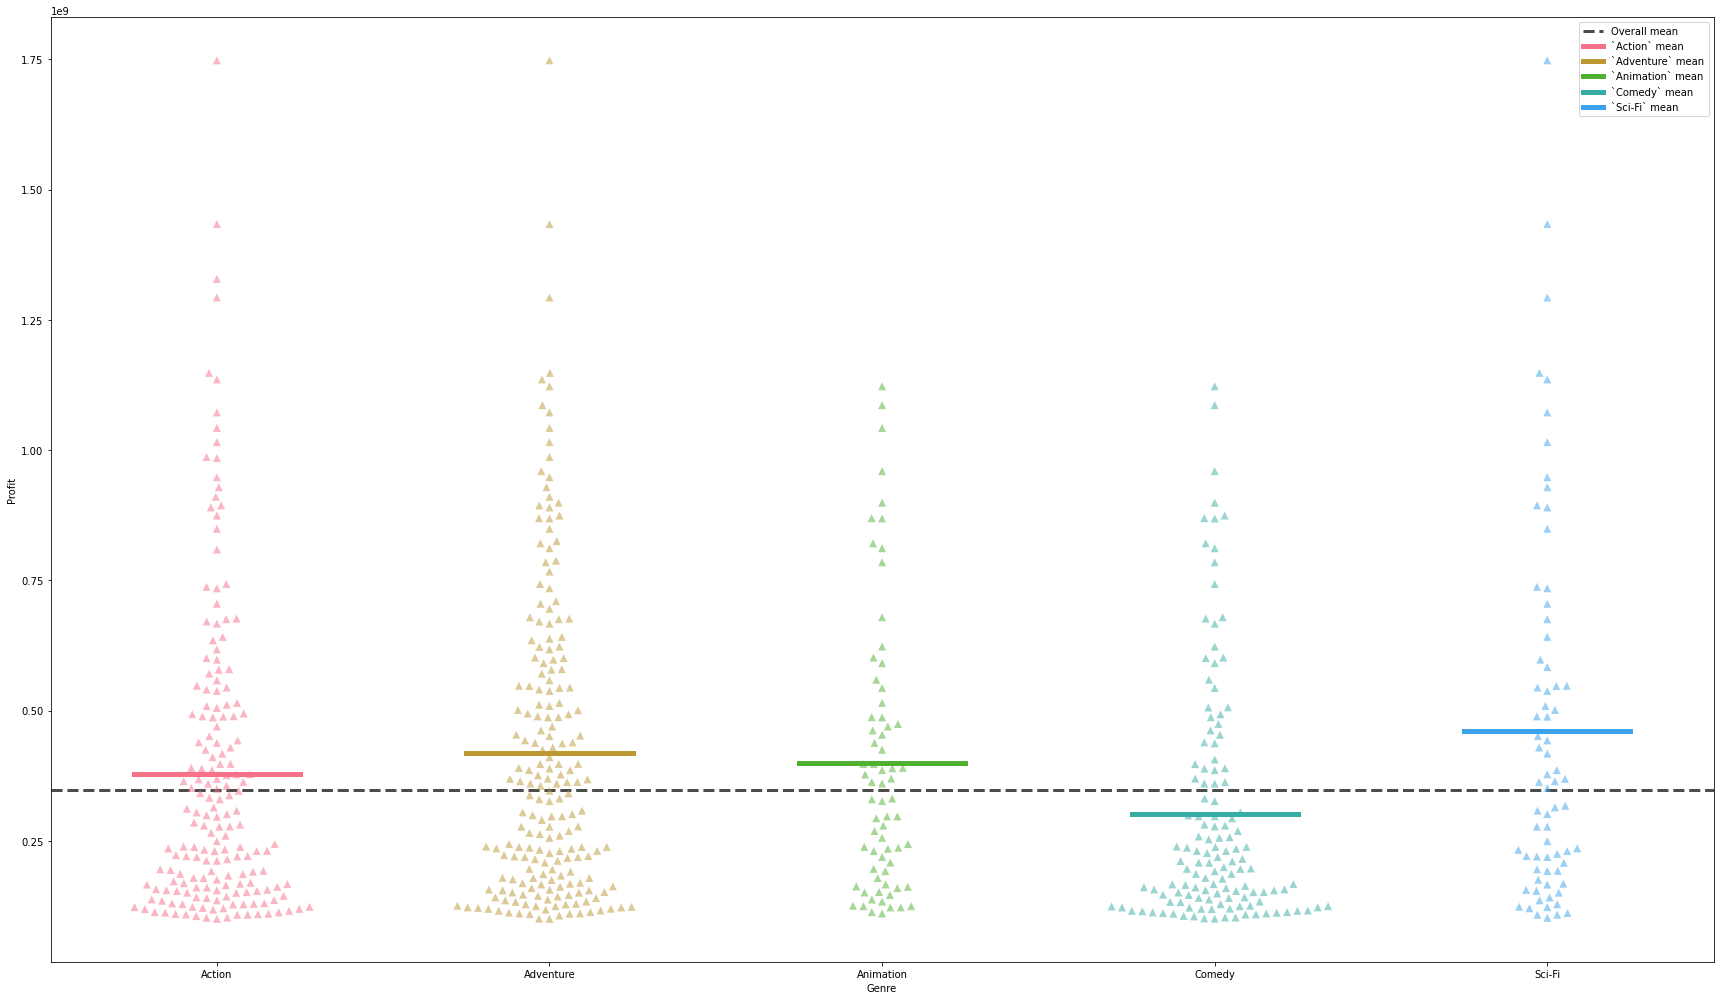

In [147]:
f, ax = plt.subplots(figsize=(24,14))
# Use specific set of colors
colors = sns.color_palette('husl')

# Data Points
ax = sns.swarmplot(
    data=df_genres,
    x="Genre",
    y="Profit",
    ax=ax,
    alpha=0.5, 
    marker='^',
    size=8,
    palette=colors
)

ax.axhline(
    df_final["profit"].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

areas = df_genres['Genre'].unique()
for i,area in enumerate(areas):
    mean = df_genres.loc[df_genres['Genre']==area]['Profit'].mean()
    # Make these lines short and near each group
    xmin = 1/len(areas) * i + 0.05
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{area}` mean',
        lw=5, ls='-', color=colors[i]
    ) 

ax.legend()
plt.tight_layout();

In [169]:
df_scifi = pd.DataFrame([movie for movie in df_final[["movie", "director", "genres", "production_budget_int", "profit"]]
                         .values if "Sci-Fi" in movie[2]], 
                        columns=["movie", "director", "genres", "budget", "profit"])
df_budget_profit = df_scifi[["budget", "profit"]].drop_duplicates()
budget = df_budget_profit["budget"]
profit = df_budget_profit["profit"]
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(df_budget_profit["budget"], df_budget_profit["profit"])
dummy_regr.score(budget, profit)

0.0

# Exploratory Data Analysis

In [9]:
#plt.scatter(df_final["id"], df_final["worldwide_gross"])
#plt.show()

# Write to File

# Appendix

In [76]:
df_movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz') #3387 x 5 domestic_gross, foreign_gross, year from
df_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t') #1560 x 12 rating, genre, director, writer, box office, runtime from Rotten Tomatoes
df_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape') #54432 x 8 rating, fresh, top critic from Rotten tomatoes
df_movies = pd.read_csv('data/tmdb.movies.csv.gz') #26517 x 10 popularity, vote_average, vote_count #from TheMoviesTB
df_directors = pd.read_sql(
    """
    Select persons.primary_name, persons.primary_profession, movie_basics.primary_title
    FROM directors
    JOIN persons
    ON directors.person_id = persons.person_id
    JOIN movie_basics
    ON movie_basics.movie_id = directors.movie_id
    """
, conn
)
df_persons = pd.read_sql(
    """
    SELECT *
    FROM known_for
    JOIN persons
    ON known_for.person_id = persons.person_id
    """
, conn
)
df_imdb[df_imdb["person_name"] == "James Cameron"] #Something we noticed is that Avatar is not a part of the IMDB data
df_imdb["year"].value_counts() #The data seems to start in 2010 and starts dwindling in 2020

def avg_profit_genre(genre_name):
    genre_combined_profit = 0
    genre_count = 0
    movie_profits = []
    for movie in df_final[["genres", "profit"]].drop_duplicates().values:
        if genre_name in movie[0]:
            if genre_name == "Music" and "Musical" in movie[0]: #makes sure to keep Musical movies out of the Music average
                continue
            movie_profits.append(movie[1])
            genre_combined_profit += movie[1]
            genre_count += 1
    return [genre_name, math.ceil(genre_combined_profit/genre_count), genre_count, movie_profits] 

genre_averages = [avg_profit_genre("Action"), avg_profit_genre("Adventure"), avg_profit_genre("Animation"), 
                avg_profit_genre("Biography"), avg_profit_genre("Comedy"), avg_profit_genre("Crime"), 
                avg_profit_genre("Documentary"), avg_profit_genre("Drama"), avg_profit_genre("Fantasy"),
                avg_profit_genre("Family"), avg_profit_genre("History"), avg_profit_genre("Horror"),
                avg_profit_genre("Music"), avg_profit_genre("Musical"), avg_profit_genre("Mystery"), 
                avg_profit_genre("Sci-Fi"), avg_profit_genre("Thriller"), avg_profit_genre("War"),
                avg_profit_genre("Western")]
df_genres = pd.DataFrame(genre_averages, columns=["Genre", "Average", "Count", "Profits"])